In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 1. Data Loading & Preprocessing

In [4]:
# 로밍데이터
roam = pd.read_csv('./data/corona_contest_data_0406/2. Roaming_data.csv')

# 날짜 변수로 변경
roam['return'] = pd.to_datetime(roam['return'], format='%Y%m%d')
roam['arrival'] = pd.to_datetime(roam['arrival'], format='%Y%m%d')
roam['departure'] = pd.to_datetime(roam['departure'], format='%Y%m%d')

# 파생변수 생성
# arrival과 return의 차를 내서 해외에 체류한 일자수를 계산함
roam['stay'] = roam['return'] - roam['arrival']

In [5]:
# covide-19 글로벌 kaggle 데이터
kag = pd.read_csv('./data/covid_19_clean_complete.csv')
kag['Date'] = pd.to_datetime(kag['Date'])
kag_dated_1 = kag.groupby(['Date'], as_index=False)['Confirmed','Deaths', 'Recovered'].sum()

# 각 컬럼별 일별 데이터 산출

cols = list(kag_dated_1.columns[1:])
for col in cols:
    col_name = "Day"+str(col)
    kag_dated_1['{}'.format(col_name)] = kag_dated_1['{}'.format(col)].diff()
    kag_dated_1['{}'.format(col_name)].iloc[0] = 0

C:\Users\Joshua\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
C:\Users\Joshua\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
# 한국데이터 추출
kag_kor = kag.loc[kag['Country/Region']=='South Korea']
kor = kag_kor.copy()
kor.reset_index(inplace=True)
# 불필요 변수 삭제
kor.drop('index', axis=1, inplace=True)
kor.drop('Province/State', axis=1, inplace=True)

# 대한민국 일별 확진자수 컬럼 형성
kor['DayConfirmed'] = kor['Confirmed'].diff()
kor['DayConfirmed'].iloc[0] = 0

C:\Users\Joshua\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
# covid-19 kor 캐글 데이터
cov_kor = pd.read_csv("./data/coronavirusdataset/Patientinfo.csv")

In [9]:
cov_kor['infection_case'].unique()

array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Gyeongsan Seorin Nursing Home',
       'Gyeongsan Cham Joeun Community Center',
       'Gyeongsan Jeil Silver Town', 'Bonghwa Pureun Nursing Home',
       'Pilgrimage to Israel', 'Milal Shelter', 'Geochang Church',
       'Changnyeong Coin Karaoke'], dtype=object)

In [30]:
# 해외유입 확진자만 추출
cov_kor_1 = cov_kor[cov_kor['infection_case'] == 'overseas inflow'].groupby(['confirmed_date'])[['patient_id']].count()

In [32]:
cov_kor_1['cumsum'] = cov_kor_1['patient_id'].cumsum()

In [34]:
cov_kor_1.reset_index(inplace=True)
cov_kor_1.rename(columns={'cumsum':'Confirmed',
                          'patient_id':'DayConfirmed', 
                          'confirmed_date':'Date'}, inplace=True)
cov_kor_1 = cov_kor_1[['Date', 'Confirmed','DayConfirmed']]

In [40]:
# 해외유입 확진자 질본 크롤링 데이터 
osi = pd.read_csv("./data/oversea_inflow.csv")
osi.rename(columns={'date':'Date'},inplace=True)

# 2. Merge Datesets
- 데이터 셋 병합은 5가지 데이터를 병합한다.
- 로밍 데이터, 캐글 글로벌 확진자수, 글로벌 데이터로 부터 추출된 한국의 확진자 데이터, 대한민국 코로나 캐글 데이터에서의 해외유입 데이터, 크롤링한 해외유입데이터이다.
- 대한민국의 해외유입감염자수를 Target Feature로 놓고 분석을 진행한다.

In [46]:
roam.head()

,return,iso,arrival,departure,count,stay
0,2020-01-31,ad,2020-01-30,2020-01-30,3,1 days
1,2020-01-31,ae,2019-12-31,2020-01-25,3,31 days
2,2020-01-31,ae,2019-12-31,2020-01-31,3,31 days
3,2020-01-31,ae,2020-01-02,2020-01-02,3,29 days
4,2020-01-31,ae,2020-01-04,2020-01-31,3,27 days


In [47]:
kag.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [48]:
kag_dated_1 = kag.groupby(['Date'], as_index=False)['Confirmed','Deaths', 'Recovered'].sum()

C:\Users\Joshua\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [82]:
new_kor = kor.drop(['Country/Region','Lat','Long','Deaths','Recovered'], axis=1)

In [86]:
new_kor.head()

,Date,Confirmed,day_confirmed
0,2020-01-22,1,1
1,2020-01-23,1,0
2,2020-01-24,2,1
3,2020-01-25,2,0
4,2020-01-26,3,1


In [98]:
new_roam = group_of_date.copy()

In [99]:
new_roam.rename(columns = {'return' : 'Date'}, inplace=True)

In [100]:
new_roam.head()

,Date,count
0,2019-12-01,23551
1,2019-12-02,20008
2,2019-12-03,17116
3,2019-12-04,19067
4,2019-12-05,18594


In [101]:
df = pd.merge(new_roam, kag_dated_1, on='Date')

In [103]:
df = pd.merge(df, new_kor, on='Date')

In [105]:
# 변수명 정리

df.rename(columns = {'count' : 'roam',
                     'Confirmed_x':'g_confirmed',
                     'Deaths':'g_deaths',
                     'Recovered':'g_recovered',
                     'dayConfirmed':'g_dayconfirmed',
                     'dayDeaths':'g_daydeaths',
                     'dayRecovered':'g_dayrecovered',
                     'Confirmed_y':'k_confirmed',
                     'day_confirmed':'k_dayconfirmed'}, inplace=True)

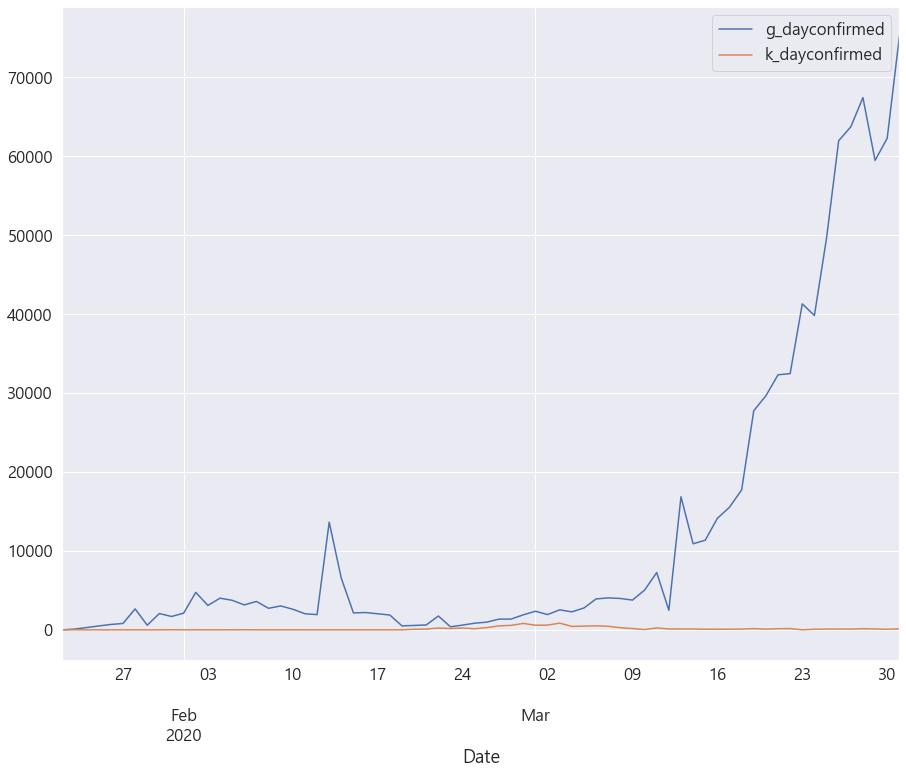

In [181]:
df.plot(kind='line', x='Date', y=['g_dayconfirmed','k_dayconfirmed'],
                                            figsize=(15,12),
                                            legend=True,
                                            grid=True)

In [182]:
# 데이터 프레임 저장
df.to_csv('./data/total.csv')